In [1]:
import numpy as np
import os
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
np.random.seed(0)

Premature Data Cleaning

In [2]:
# # read the dfs
# df = pd.read_feather("cluster_max_1000/clustered_df.feather").set_index("key").sort_values(["City","Cluster","unique_cluster","frame_number"])
# seqs = pd.read_feather("max_distance_of_50.feather").set_index(["seq_key","new_unique_cluster"])

# # only keeps seqs with len 5
# seqs["len"] = seqs["keys"].apply(len)
# seqs = seqs.loc[seqs.len >= 5]
# df = df.loc[np.concatenate(seqs["keys"].values)]

# # set cluster id to images
# for (seq_key,cluster_id), val_df in tqdm.tqdm(seqs.iterrows()):

#     df.loc[val_df["keys"],"unique_cluster"] = cluster_id

# # rename clustesrs for clarity
# df.rename(columns={"Cluster":"City_Cluster","unique_cluster":"img_seq"},inplace=True)

# df.reset_index().to_feather("max_50_ready_for_split.feather")
# seqs.reset_index().to_feather("max_50_seqs_ready_for_split.feather")

12386it [00:18, 647.59it/s]

Load the Data

In [3]:
df = pd.read_feather("max_50_ready_for_split.feather").set_index("key")
seqs = pd.read_feather("max_50_seqs_ready_for_split.feather").set_index(["seq_key","new_unique_cluster"])

Give seqs view counts

In [4]:
clusester_assingnments = df.groupby("sequence_key")["City_Cluster"].max()
seq_in = [i[0] for i in seqs.index.values]

seqs["City_Cluster"] = [clusester_assingnments.loc[f] for f in seq_in]

In [5]:
trimmed_seqs = []

# trim sequnces to multiple sub seuqnces of length 5
for ((seq_key,cluster_id), ser) in seqs.iterrows():

    keys = ser[3]
    frames = ser[2]
    slice = np.arange(5,len(keys)+1,2)

    for i in slice:

        trimmed_seqs.append( [keys[i-5:i],frames[i-5:i],seq_key,cluster_id,ser[6],ser[-1]])

# create df
trimmed_seqs = pd.DataFrame(trimmed_seqs,columns=["keys","frames","seq_key","cluster_id","view_direction","City_Cluster"])
# add pahts
trimmed_seqs["Paths"] = [df.loc[key,"Path"].values    for key in tqdm.tqdm(trimmed_seqs["keys"].values)]
trimmed_seqs.Paths = trimmed_seqs.Paths + "/images/" + trimmed_seqs["keys"] + ".jpg"

def get_city(paths):
    path = paths[0]
    return path[22:path.find("/",22)]

# add city
trimmed_seqs["City"] = trimmed_seqs["Paths"].apply(get_city)

trimmed_seqs.to_feather("trimmed_seqs.feather")

In [30]:
trimmed_seqs = pd.read_feather("trimmed_seqs.feather")

Get View Counts

In [31]:
view_counts = {}

for seq_key, series in trimmed_seqs.groupby(["City","City_Cluster"])["view_direction"]:

    view_counts[seq_key] =  [(series == i).sum() for i in  ["Forward",'Sideways',"Backward"]]

view_counts = pd.DataFrame.from_dict(view_counts,orient="index",columns=["Forward",'Sideways',"Backward"]).set_index(pd.MultiIndex.from_tuples(view_counts.keys()))

For this task we only want to have the Sideways

In [42]:
n_sid = (trimmed_seqs.view_direction == "Sideways").sum()
n_sid * 0.1

2545.7000000000003

In [44]:
sorted = view_counts.sort_values("Sideways")
sorted = sorted[sorted["Sideways"]>0]

In [52]:
sid = sorted["Sideways"]
sid

toronto    0         2
ottawa     3         2
goa        6         3
saopaulo   5         4
austin     5         6
phoenix    15       16
amsterdam  3        19
austin     2        25
london     1        27
budapest   0        31
saopaulo   1        49
cph        0        66
paris      0        75
manila     0        89
melbourne  0       126
bangkok    0       185
sf         0       206
tokyo      0       271
berlin     0       279
london     0       319
austin     0       587
phoenix    0       719
trondheim  0      1178
moscow     0      1857
helsinki   0      2202
amsterdam  0      2556
ottawa     0     14558
Name: Sideways, dtype: int64

In [144]:
vals = ["trondheim","austin","phoenix","cph"]
sid.loc[vals,[0,0,0,0]].sum()

2550

In [145]:
test = ["moscow","berlin","london","manila"]
sid.loc[test,[0,0,0,0]].sum()


2544

In [146]:
val_mask = (trimmed_seqs.City.apply(lambda x: x in vals)) & (trimmed_seqs.City_Cluster == 0)
test_mask = (trimmed_seqs.City.apply(lambda x: x in test)) & (trimmed_seqs.City_Cluster == 0)

val = trimmed_seqs.loc[val_mask]
test = trimmed_seqs.loc[test_mask]

In [147]:
front = test.loc[test["view_direction"]!="Sideways"].sample(n=2544,random_state = 0)

test_df = pd.concat([front,test.loc[test["view_direction"]=="Sideways"]]).sample(frac= 1,random_state = 0)

In [148]:
front = val.loc[val["view_direction"]!="Sideways"].sample(n=2544,random_state = 0)

val_df = pd.concat([front,val.loc[val["view_direction"]=="Sideways"]]).sample(frac= 1,random_state = 0)

In [149]:
train = trimmed_seqs.loc[~ (val_mask | test_mask)]
front = train.loc[train["view_direction"]!="Sideways"].sample(n=20363,random_state = 0)
train_df = pd.concat([front,train.loc[train["view_direction"]=="Sideways"]]).sample(frac= 1,random_state = 0)

In [150]:
train_df["ds_type"] = "train"
val_df["ds_type"] = "val"
test_df["ds_type"] = "test"

df = pd.concat([train_df,val_df,test_df])

In [151]:
df.value_counts("view_direction")

view_direction
Sideways    25457
Forward     25285
Backward      166
dtype: int64

Lets have a look at the images sequences

100%|██████████| 25/25 [00:01<00:00, 22.86it/s]


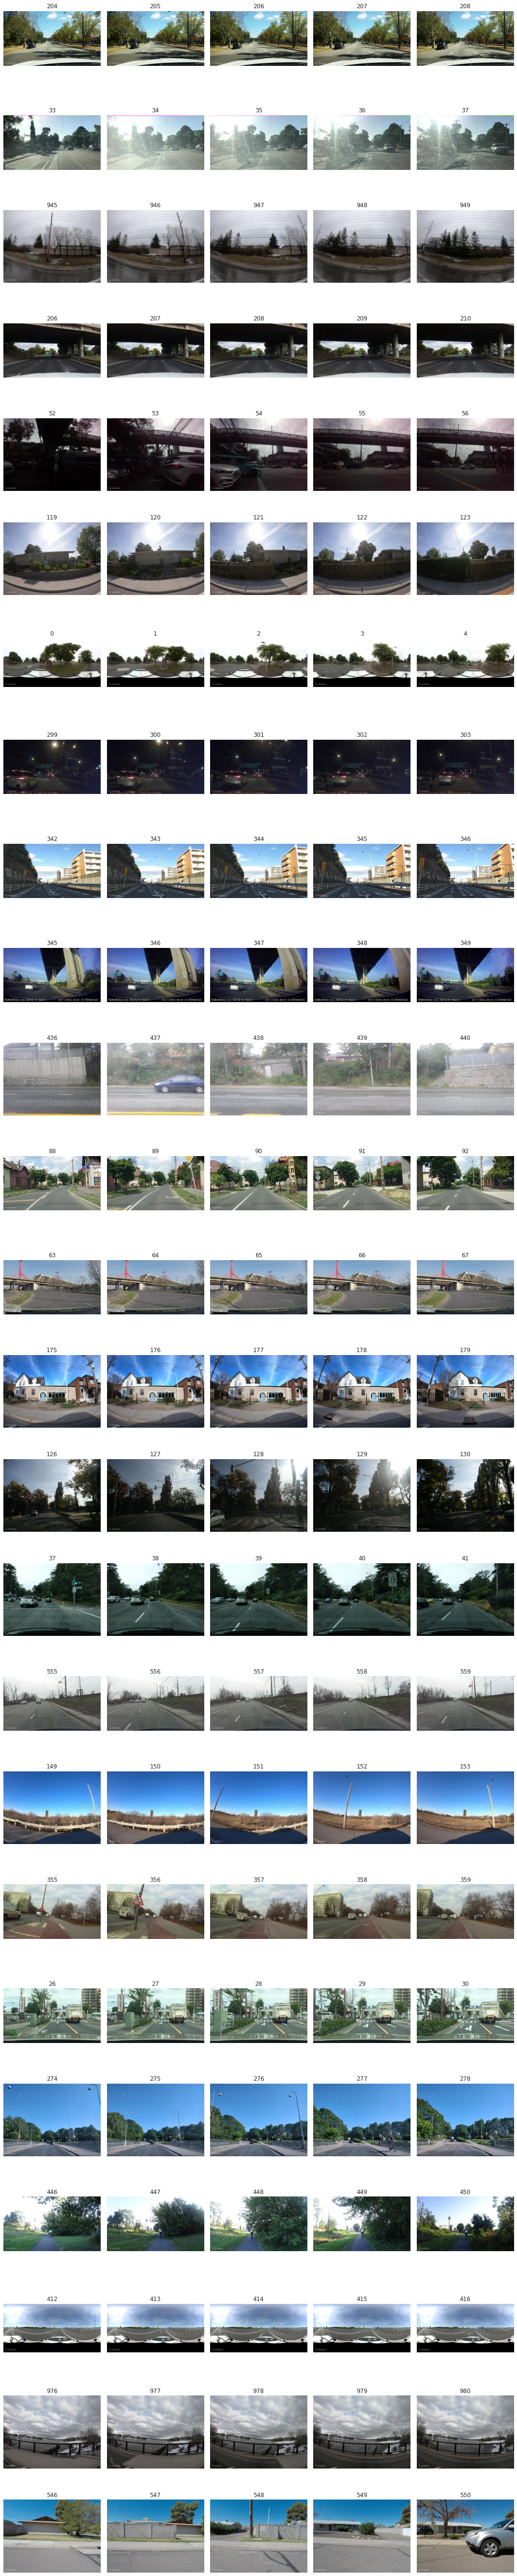

In [142]:
n = 25
p = df.sample(n=n)
fig,ax = plt.subplots(n,5,figsize=(15,3*n))

for i in tqdm.tqdm(range(n)):

    s = p.iloc[i]

    paths = s["Paths"]
    frames = s["frames"]

    for pos,(img,f) in enumerate(zip(paths,frames)):
        ax[i,pos].imshow(plt.imread("../" + img))
        ax[i,pos].axis('off')
        ax[i,pos].set_title(f)


plt.tight_layout()
plt.show()


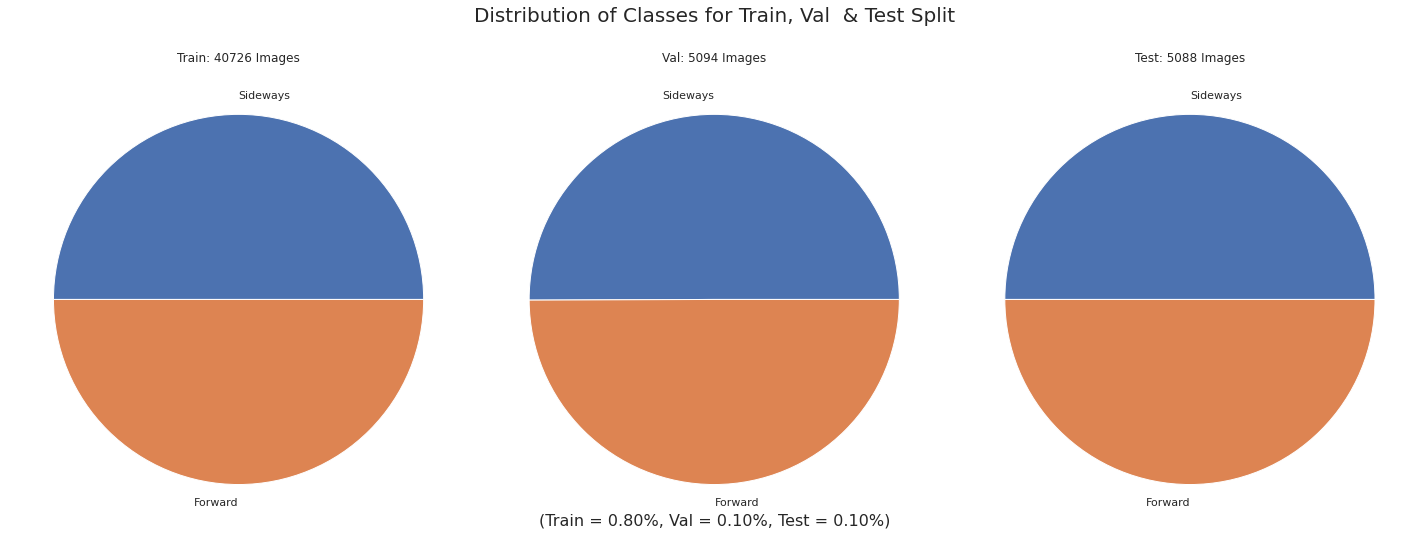

In [129]:
sns.set_theme()
def plot_pie(df,ax):

    x = df["view_direction"].value_counts()

    ax.pie(x.values,labels = x.index )

fig,ax = plt.subplots(1,3,figsize=[20,8])

ax[0].title.set_text(f'Train: {len(train_df)} Images')
ax[1].title.set_text(f'Val: {len(val_df)} Images')
ax[2].title.set_text(f'Test: {len(test_df)} Images')


plot_pie(train_df,ax[0])
plot_pie(val_df,ax[1])
plot_pie(test_df,ax[2])
plt.suptitle(f"Distribution of Classes for Train, Val  & Test Split",fontsize=20)
plt.tight_layout()
plt.figtext(0.5, 0.08, f"(Train = {len(train_df)/len(df):.2f}%, Val = {len(val_df)/len(df):.2f}%, Test = {len(test_df)/len(df):.2f}%)", wrap=True, horizontalalignment='center', fontsize=16)
#plt.savefig("Imgs/Training Split.jpg")
plt.show()

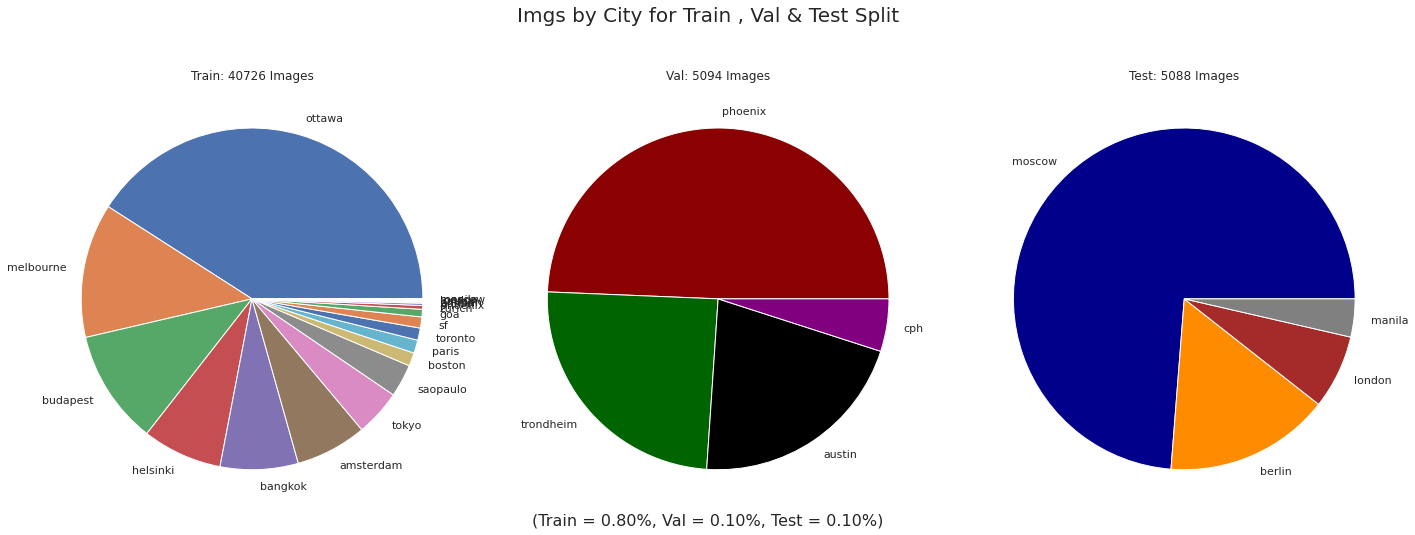

In [130]:
def plot_pie(df,ax,colors = None):

    x = df["City"].value_counts()

    ax.pie(x.values,labels = x.index ,colors = colors)

fig,ax = plt.subplots(1,3,figsize=[20,8])

ax[0].title.set_text(f'Train: {len(train_df)} Images')
ax[1].title.set_text(f'Val: {len(val_df)} Images')
ax[2].title.set_text(f'Test: {len(test_df)} Images')


plot_pie(train_df,ax[0])
plot_pie(val_df,ax[1],colors=["darkred","darkgreen","black","purple"])
plot_pie(test_df,ax[2],colors=["darkblue","darkorange","brown","grey"])
plt.suptitle(f"Imgs by City for Train , Val & Test Split", fontsize=20)
plt.figtext(0.5, 0.08, f"(Train = {len(train_df)/len(df):.2f}%, Val = {len(val_df)/len(df):.2f}%, Test = {len(test_df)/len(df):.2f}%)", wrap=True, horizontalalignment='center', fontsize=16)
plt.tight_layout()
#plt.savefig("Imgs/Citys Split.jpg")
plt.show()